# T81-558: Applications of Deep Neural Networks
**Module 6: Convolutional Neural Networks (CNN) for Computer Vision**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module Video Material

Main video lecture:

* [Part 6.1: Image Processing in Python](https://www.youtube.com/watch?v=Oe0-hX4KSZQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN&index=18)
* [Part 6.2: Keras Neural Networks for Digits and Fashion MINST](https://www.youtube.com/watch?v=GDlI-3O5r6I&index=19&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 6.3: Implementing a ResNet in Keras](https://www.youtube.com/watch?v=zUZRUTJbYm8&index=20&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 6.4: Computer Vision with OpenCV](https://www.youtube.com/watch?v=zUZRUTJbYm8&index=20&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)
* [Part 6.5: Recognizing Multiple Images with Darknet](https://www.youtube.com/watch?v=zUZRUTJbYm8&index=20&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN)

# Part 6.1: Image Processing in Python

We will make use of images to demonstrate auto encoders.  To use images in Python, we will make use of the Pillow package.  This package can be installed with the following command.  

```
pip install pillow
```

The following program uses Pillow to load and display an image.

In [ ]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

print(np.asarray(img))

img

### Creating Images (from pixels) in Python

Pillow can also be used to create an image from a 3D numpy cube.  The rows and columns specify the pixels.  The depth, of 3, specifies red, green and blue.  Here a simple image is created.

In [ ]:
from PIL import Image
import numpy as np

w, h = 64, 64
data = np.zeros((h, w, 3), dtype=np.uint8)

# Yellow
for row in range(32):
    for col in range(32):
        data[row,col] = [255,255,0]
        
# Red
for row in range(32):
    for col in range(32):
        data[row+32,col] = [255,0,0]
        
# Green
for row in range(32):
    for col in range(32):
        data[row+32,col+32] = [0,255,0]        
        
# Blue
for row in range(32):
    for col in range(32):
        data[row,col+32] = [0,0,255]                
        

img = Image.fromarray(data, 'RGB')
img

### Transform Images in Python (at the pixel level)

We can combine the last two programs and modify images.  Here we take the mean color of each pixel and form a grayscale image.

In [ ]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = np.zeros((rows, cols, 3), dtype=np.uint8)
for row in range(rows):
    for col in range(cols):
        t = np.mean(img_array[row,col])
        img2_array[row,col] = [t,t,t]

img2 = Image.fromarray(img2_array, 'RGB')
img2  

# Standardize Images

When processing several images together it is sometimes important to standardize them.  The following code reads a sequence of images and causes them to all be of the same size and perfectly square.  If the input images are not square, cropping will occur.

In [ ]:
%matplotlib inline
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML

#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

images = [
    "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/ff/WashU_Graham_Chapel.JPG",
    "https://upload.wikimedia.org/wikipedia/commons/9/9e/SeigleHall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/a/aa/WUSTLKnight.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/32/WashUABhall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/c/c0/Brown_Hall.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f4/South40.jpg"    
]


def make_square(img):
    cols,rows = img.size
    
    if rows>cols:
        pad = (rows-cols)/2
        img = img.crop((pad,0,cols,cols))
    else:
        pad = (cols-rows)/2
        img = img.crop((0,pad,rows,rows))
    
    return img
    
x = [] 
    
for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.load()
    img = make_square(img)
    img = img.resize((128,128), Image.ANTIALIAS)
    print(url)
    display(img)
    img_array = np.asarray(img)
    img_array = img_array.flatten()
    img_array = img_array.astype(np.float32)
    img_array = (img_array-128)/128
    x.append(img_array)
    

x = np.array(x)

print(x.shape)


### Adding Noise to an Image

Auto encoders can handle noise.  First it is important to see how to add noise to an image.  There are many ways to add such noise.  The following code adds random black squares to the image to produce noise.

In [ ]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline


def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/20) # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

url = "https://upload.wikimedia.org/wikipedia/commons/9/92/Brookings.jpg"
#url = "http://www.heatonresearch.com/images/about-jeff.jpg"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = img_array.astype(np.uint8)
print(img2_array.shape)
img2_array = add_noise(img2_array)
img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

# Part 6.2: Keras Neural Networks for Digits and Fashion MINST

# Computer Vision

This class will focus on computer vision.  There are some important differences and similarities with previous neural networks.

* We will usually use classification, though regression is still an option.
* The input to the neural network is now 3D (height, width, color)
* Data are not transformed, no z-scores or dummy variables.
* Processing time is much longer.
* We now have different layer times: dense layers (just like before), convolution layers and max pooling layers.
* Data will no longer arrive as CSV files. TensorFlow provides some utilities for going directly from image to the input for a neural network.


# Computer Vision Data Sets

There are many data sets for computer vision.  Two of the most popular are the MNIST digits data set and the CIFAR image data sets.

## MNIST Digits Data Set

The [MNIST Digits Data Set](http://yann.lecun.com/exdb/mnist/) is very popular in the neural network research community.  A sample of it can be seen here:

![MNIST Data Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_mnist.png "MNIST Data Set")

This data set was generated from scanned forms.

![Exam](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_exam.png "Exam")


## CIFAR Data Set

The [CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) datasets are also frequently used by the neural network research community.

![cifar-10](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_cifar.png "cifar-10")

The CIFAR-10 data set contains low-rez images that are divided into 10 classes.  The CIFAR-100 data set contains 100 classes in a hierarchy. 

# Other Resources

* [Imagenet:Large Scale Visual Recognition Challenge 2014](http://image-net.org/challenges/LSVRC/2014/index)
* [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/) - PhD student/instructor at Stanford.
    * [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/) - Stanford course on computer vision/CNN's.
        * [CS231n - GitHub](http://cs231n.github.io/)
    * [ConvNetJS](http://cs.stanford.edu/people/karpathy/convnetjs/) - JavaScript library for deep learning.
 

# Convolutional Neural Networks (CNNs)

The convolutional neural network (CNN) is a neural network technology that has profoundly impacted the area of computer vision (CV). Fukushima (1980) introduced the original concept of a convolutional neural network, and LeCun, Bottou, Bengio & Haffner (1998) greatly improved this work. From this research, Yan LeCun introduced the famous LeNet-5 neural network architecture. This class follows the LeNet-5 style of convolutional neural network.

**A LeNET-5 Network (LeCun, 1998)**
![LENET5](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_lenet5.png "LENET5")

So far we have only seen one layer type (dense layers).  By the end of this course we will have seen:

* **Dense Layers** - Fully connected layers.  (introduced previously)
* **Convolution Layers** - Used to scan across images. (introduced this class)
* **Max Pooling Layers** - Used to downsample images. (introduced this class)
* **Dropout Layer** - Used to add regularization. (introduced next class)

## Convolution Layers

The first layer that we will examine is the convolutional layer. We will begin by looking at the hyper-parameters that you must specify for a convolutional layer in most neural network frameworks that support the CNN:

* Number of filters
* Filter Size
* Stride
* Padding
* Activation Function/Non-Linearity

The primary purpose for a convolutional layer is to detect features such as edges, lines, blobs of color, and other visual elements. The filters can detect these features. The more filters that we give to a convolutional layer, the more features it can detect.

A filter is a square-shaped object that scans over the image. A grid can represent the individual pixels of a grid. You can think of the convolutional layer as a smaller grid that sweeps left to right over each row of the image. There is also a hyper parameter that specifies both the width and height of the square-shaped filter. Figure 10.1 shows this configuration in which you see the six convolutional filters sweeping over the image grid:

A convolutional layer has weights between it and the previous layer or image grid. Each pixel on each convolutional layer is a weight. Therefore, the number of weights between a convolutional layer and its predecessor layer or image field is the following:

```
[FilterSize] * [FilterSize] * [# of Filters]
```

For example, if the filter size were 5 (5x4) for 10 filters, there would be 250 weights.

You need to understand how the convolutional filters sweep across the previous layer’s output or image grid. Figure 10.2 illustrates the sweep:

![CNN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_cnn_grid.png "CNN")

The above figure shows a convolutional filter with a size of 4 and a padding size of 1. The padding size is responsible for the boarder of zeros in the area that the filter sweeps. Even though the image is actually 8x7, the extra padding provides a virtual image size of 9x8 for the filter to sweep across. The stride specifies the number of positions at which the convolutional filters will stop. The convolutional filters move to the right, advancing by the number of cells specified in the stride. Once the far right is reached, the convolutional filter moves back to the far left, then it moves down by the stride amount and
continues to the right again.

Some constraints exist in relation to the size of the stride. Obviously, the stride cannot be 0. The convolutional filter would never move if the stride were set to 0. Furthermore, neither the stride, nor the convolutional filter size can be larger than the previous grid. There are additional constraints on the stride (s), padding (p) and the filter width (f) for an image of width (w). Specifically, the convolutional filter must be able to start at the far left or top boarder, move a certain number of strides, and land on the far right or bottom boarder. The following equation shows the number of steps a convolutional operator
must take to cross the image:

$ steps = \frac{w - f + 2p}{s+1} $

The number of steps must be an integer. In other words, it cannot have decimal places. The purpose of the padding (p) is to be adjusted to make this equation become an integer value.

## Max Pooling Layers

Max-pool layers downsample a 3D box to a new one with smaller dimensions. Typically, you can always place a max-pool layer immediately following convolutional layer. The LENET shows the max-pool layer immediately after layers C1 and C3. These max-pool layers progressively decrease the size of the dimensions of the 3D boxes passing through them. This technique can avoid overfitting (Krizhevsky, Sutskever & Hinton, 2012).

A pooling layer has the following hyper-parameters:

* Spatial Extent (f )
* Stride (s)

Unlike convolutional layers, max-pool layers do not use padding. Additionally, max-pool layers have no weights, so training does not affect them. These layers simply downsample their 3D box input. The 3D box output by a max-pool layer will have a width equal to this equation:

$ w_2 = \frac{w_1 - f}{s + 1} $

The height of the 3D box produced by the max-pool layer is calculated similarly with this equation:

$ h_2 = \frac{h_1 - f}{s + 1} $

The depth of the 3D box produced by the max-pool layer is equal to the depth the 3D box received as input. The most common setting for the hyper-parameters of a max-pool layer are f =2 and s=2. The spatial extent (f) specifies that boxes of 2x2 will be scaled down to single pixels. Of these four pixels, the pixel with the maximum value will represent the 2x2 pixel in the new grid. Because squares of size 4 are replaced with size 1, 75% of the pixel information is lost. The following figure shows this transformation as a 6x6 grid becomes a 3x3:

![MaxPool](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_conv_maxpool.png "MaxPool")

Of course, the above diagram shows each pixel as a single number. A grayscale image would have this characteristic. For an RGB image, we usually take the average of the three numbers to determine which pixel has the maximum value.

[More information on CNN's](http://cs231n.github.io/convolutional-networks/)

# TensorFlow with CNNs

The following sections describe how to use TensorFlow/Keras with CNNs.

### Access to Data Sets - DIGITS

Keras provides built in access classes for MNIST.  It is important to note that MNIST data arrives already separated into two sets:

* **train** - Neural network will be trained with this.
* **test** - Used for validation.

In [7]:
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


### Display the Digits 

The following code shows what the MNIST files contain.

In [8]:
# Display as text
from IPython.display import display
import pandas as pd

print("Shape for dataset: {}".format(x_train.shape))
print("Labels: {}".format(y_train))

# Single MNIST digit
single = x_train[0]
print("Shape for single: {}".format(single.shape))

display(pd.DataFrame(single.reshape(28,28)))

Shape for dataset: (60000, 28, 28)
Labels: [5 0 4 ... 5 6 8]
Shape for single: (28, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,...,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,...,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,...,0,0,0,0,0,0,0,0,0,0


Image (#105): Which is digit '1'


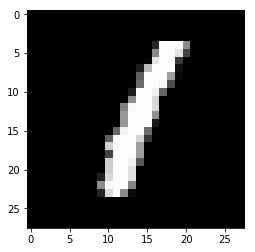

In [9]:
# Display as image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
digit = 105 # Change to choose new digit
a = x_train[digit]
plt.imshow(a, cmap='gray', interpolation='nearest')
print("Image (#{}): Which is digit '{}'".format(digit,y_train[digit]))

<Figure size 432x288 with 0 Axes>

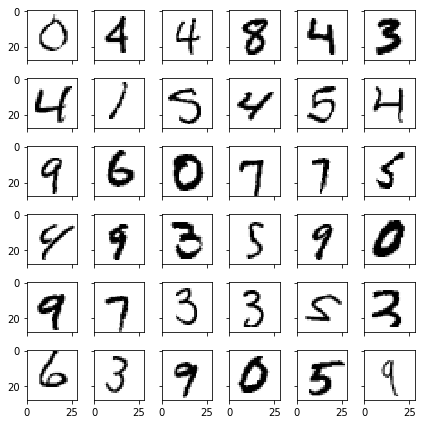

In [10]:
import random

ROWS = 6
random_indices = random.sample(range(x_train.shape[0]), ROWS*ROWS)

sample_images = x_train[random_indices, :]

plt.clf()

fig, axes = plt.subplots(ROWS,ROWS, 
                         figsize=(ROWS,ROWS),
                         sharex=True, sharey=True) 

for i in range(ROWS*ROWS):
    subplot_row = i//ROWS 
    subplot_col = i%ROWS
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_xbound([0,28])

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
batch_size = 128
num_classes = 10
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))
# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])


### Training/Fitting CNN - DIGITS

The following code will train the CNN for 20,000 steps.  This can take awhile, you might want to scale the step count back. GPU training can help.  My results:

* CPU Training Time: Elapsed time: 1:50:13.10
* GPU Training Time: Elapsed time: 0:13:43.06

In [ ]:
import tensorflow as tf
import time

start_time = time.time()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

### Evaluate Accuracy - DIGITS

Note, if you are using a GPU you might get the **ResourceExhaustedError**.  This occurs because the GPU might not have enough ram to predict the entire data set at once.  

In [2]:
# Predict using either GPU or CPU, send the entire dataset.  This might not work on the GPU.
# Set the desired TensorFlow output level for this example
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

NameError: name 'model' is not defined

GPUs are most often used for training rather than prediction.  For prediction either disable the GPU or just predict on a smaller sample.  If your GPU has enough memory, the above prediction code may work just fine.  If not, just prediction on a sample with the following code:

In [ ]:
from sklearn import metrics

# For GPU just grab the first 100 images
small_x = x_test[1:100]
small_y = y_test[1:100]
small_y2 = np.argmax(small_y,axis=1)
pred = model.predict(small_x)
pred = np.argmax(pred,axis=1)
score = metrics.accuracy_score(small_y2, pred)
print('Accuracy: {}'.format(score))

### MINST Fashion

In [3]:
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


### Display the Apparel 

The following code shows what the Fashion MNIST files contain.

In [4]:
# Display as text
from IPython.display import display
import pandas as pd

print("Shape for dataset: {}".format(x_train.shape))
print("Labels: {}".format(y_train))

# Single MNIST digit
single = x_train[0]
print("Shape for single: {}".format(single.shape))

display(pd.DataFrame(single.reshape(28,28)))

Shape for dataset: (60000, 28, 28)
Labels: [9 0 0 ... 3 0 5]
Shape for single: (28, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,4,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,54,0,0,0,1,3,4,0,0,3
5,0,0,0,0,0,0,0,0,0,0,...,144,123,23,0,0,0,0,12,10,0
6,0,0,0,0,0,0,0,0,0,0,...,107,156,161,109,64,23,77,130,72,15
7,0,0,0,0,0,0,0,0,0,0,...,216,163,127,121,122,146,141,88,172,66
8,0,0,0,0,0,0,0,0,0,1,...,223,223,215,213,164,127,123,196,229,0
9,0,0,0,0,0,0,0,0,0,0,...,235,227,224,222,224,221,223,245,173,0


Image (#90): Which is digit '9'


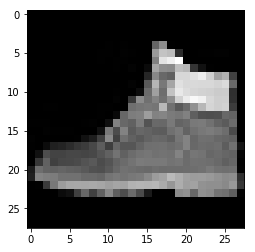

In [5]:
# Display as image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
digit = 90 # Change to choose new article
a = x_train[digit]
plt.imshow(a, cmap='gray', interpolation='nearest')
print("Image (#{}): Which is digit '{}'".format(digit,y_train[digit]))

<Figure size 432x288 with 0 Axes>

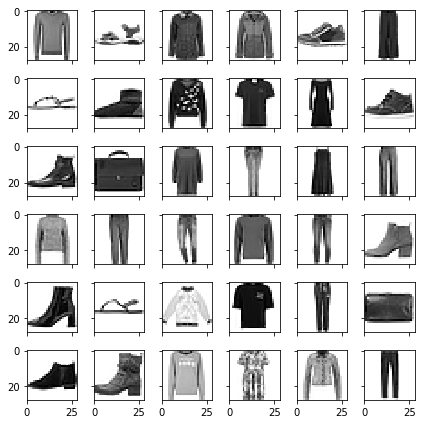

In [6]:
import random

ROWS = 6
random_indices = random.sample(range(x_train.shape[0]), ROWS*ROWS)

sample_images = x_train[random_indices, :]

plt.clf()

fig, axes = plt.subplots(ROWS,ROWS, 
                         figsize=(ROWS,ROWS),
                         sharex=True, sharey=True) 

for i in range(ROWS*ROWS):
    subplot_row = i//ROWS 
    subplot_col = i%ROWS
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    
    ax.set_xbound([0,28])

plt.tight_layout()
plt.show()


### Training/Fitting CNN - Fashion

The following code will train the CNN for 20,000 steps.  This can take awhile, you might want to scale the step count back. GPU training can help.  My results:

* CPU Training Time: Elapsed time: 1:50:13.10
* GPU Training Time: Elapsed time: 0:13:43.06

In [9]:
import tensorflow.keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
batch_size = 128
num_classes = 10
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))
# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])


x_train shape: (60000, 28, 28, 1)
Training samples: 60000
Test samples: 10000


In [10]:
import tensorflow as tf
import time

start_time = time.time()

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 - 66s - loss: 0.5300 - accuracy: 0.8143 - val_loss: 0.3522 - val_accuracy: 0.8748
Epoch 2/12
60000/60000 - 73s - loss: 0.3487 - accuracy: 0.8748 - val_loss: 0.2931 - val_accuracy: 0.8926
Epoch 3/12
60000/60000 - 69s - loss: 0.3008 - accuracy: 0.8914 - val_loss: 0.2643 - val_accuracy: 0.9050
Epoch 4/12
60000/60000 - 64s - loss: 0.2739 - accuracy: 0.9007 - val_loss: 0.2493 - val_accuracy: 0.9084
Epoch 5/12
60000/60000 - 65s - loss: 0.2479 - accuracy: 0.9095 - val_loss: 0.2357 - val_accuracy: 0.9145
Epoch 6/12
60000/60000 - 62s - loss: 0.2283 - accuracy: 0.9167 - val_loss: 0.2288 - val_accuracy: 0.9182
Epoch 7/12
60000/60000 - 63s - loss: 0.2074 - accuracy: 0.9245 - val_loss: 0.2250 - val_accuracy: 0.9184
Epoch 8/12
60000/60000 - 64s - loss: 0.1982 - accuracy: 0.9264 - val_loss: 0.2193 - val_accuracy: 0.9196
Epoch 9/12
60000/60000 - 65s - loss: 0.1819 - accuracy: 0.9326 - val_loss: 0.2205 - val_accuracy: 0.9212
Epoch

KeyboardInterrupt: 

# Part 6.3: Implementing a ResNet in Keras

In [1]:
from __future__ import print_function
import tensorflow.keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200 # 200
data_augmentation = True
num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

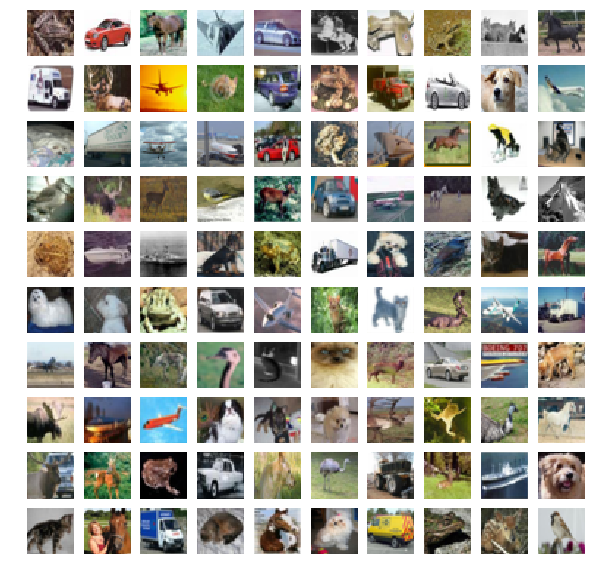

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from six.moves import cPickle 

ROWS = 10

x = x_train.astype("uint8")

fig, axes1 = plt.subplots(ROWS,ROWS,figsize=(10,10))
for j in range(ROWS):
    for k in range(ROWS):
        i = np.random.choice(range(len(x)))
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(x[i:i+1][0])

# Part 6.4: Computer Vision with OpenCV

# Part 6.5: Recognizing Multiple Images with Darknet

# Module 6 Assignment

You can find the first assignment here: [assignment 6](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class1.ipynb)